https://fdasrsf-python.readthedocs.io/en/latest/time_warping.html

In [170]:
from skfda.preprocessing.registration import landmark_registration, landmark_registration_warping
from skfda.representation.grid import FDataGrid

In [171]:
from fdasrsf.time_warping import align_fPCA

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.interpolate import interp1d

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

for att in ['axes.labelsize', 'axes.titlesize', 'legend.fontsize',
            'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize']:
    plt.rcParams[att] = 13

171


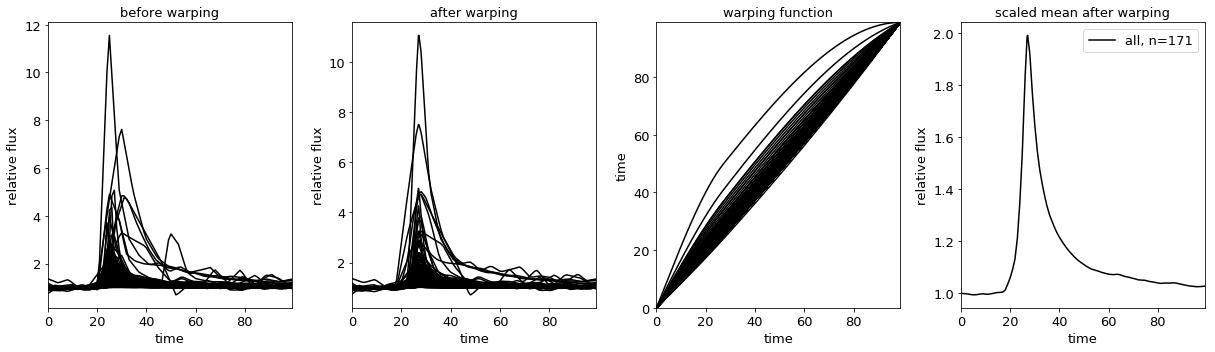

In [251]:

df = pd.read_csv("../flare_tables/20200227_vetted_flares_lacking_some.csv")
df = df[df.real == 1] 
df = df[df.complex == 0]
df = df[df.ampl_rec > .01]
#df = df[df.ampl_rec .< 1., :]
df = df[(df.cstop-df.cstart) < 60]
df = df[(df.cstop-df.cstart) > 4]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(17,5))
    

for cond, S, color in [#((df.st == 6), "M6", "red"),
                       #((df.st == 7), "M7", "blue"),
                       #((df.st == 8), "M8", "orange"),
                       #((df.st == 9), "M9", "green"),
                     #((df.st > 6), ">M6", "grey"),
                       ((df.st>5),"all", "k")
                      ]:
    d = df[cond]
    n = d.shape[0]
    print(n)
    a = np.ones((n, 100));
    

    for i in range(n):
        l = d[["TIC","sector","cstart"]].iloc[i]
        s =f"{str(l.TIC).zfill(16)}_{l.sector}_{l.cstart}_rel.csv"
        f = pd.read_csv(f"../flare_snippets/{s}")
        flux = interp1d(f.c, f.f, kind='linear')
        xnew = np.linspace(f.c.values[0], f.c.values[-1],100)
        y2 = (flux(xnew) -1.) * 100 / f.shape[0] + 1.
        a[i,:] =  y2
        axes[0].plot(y2, c=color)
    axes[0].set_xlabel("time")
    axes[0].set_ylabel("relative flux")
    axes[0].set_title("before warping")



    landmarks = np.array([np.argmax(j) for j in a])

    dat = FDataGrid(a, axes_labels=["time", "relative flux"], sample_points=np.arange(100))

    lmreg = landmark_registration(dat, landmarks)
    lmregwarp = landmark_registration_warping(dat, landmarks)

    lmreg.plot(axes[1],c=color)
    axes[1].set_title("after warping")
    lmregwarp.plot(axes[2], c=color)
    axes[2].set_title("warping function")
    axes[2].set_xlabel("time")
    axes[2].set_ylabel("time")
    axes[2].set_ylim(0,99)
    ma = lmreg.mean().data_matrix[0].T[0].max()-1.
    LMREGMEAN = (lmreg.mean() - 1.) / ma + 1.
    MREGSTD = (lmreg.var() - .1)
    ((lmreg.mean()-1.)/ma +1.).plot(axes[3],label=f"{S}, n={n}", c=color)
    #LMREGMEAN.plot(axes[3],label=f"{S}, n={n}", c="r")
    axes[3].set_ylabel("relative flux")
    axes[3].set_title("scaled mean after warping")
plt.legend()
plt.tight_layout()
for ax in axes:
    ax.set_xlim(0,99)
plt.savefig(f"../plots/{tstamp}_landmark_registration_linear_{S}.png", dpi=300)

pre-flare dip giampapa 1982
filament blocking the flare optically

CME piston stop, 

<ErrorbarContainer object of 3 artists>

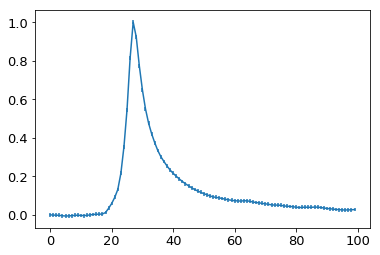

In [252]:
flux = LMREGMEAN.data_matrix[0].T[0] -1.
time = LMREGMEAN.sample_points[0].astype(float)
flux_err = .01#MREGSTD.data_matrix[0].T[0]

plt.errorbar(time, flux, yerr=flux_err)

In [253]:
import scipy.optimize as op
nll = lambda *args: -loglikelihood(*args)
result = op.minimize(nll, [26.8,14.,1.], args=(time, flux, flux_err),options={ 'disp': True})
tpeak_ml, dur_ml, ampl_ml = result["x"]

         Current function value: -226.046747
         Iterations: 14
         Function evaluations: 136
         Gradient evaluations: 27


In [254]:
tpeak_ml, dur_ml, ampl_ml

(26.82385167922586, 14.215581838979386, 1.0516158218399825)

In [255]:
# tpeak_ml, dur_ml, ampl_ml = 25.8, 20., 8.

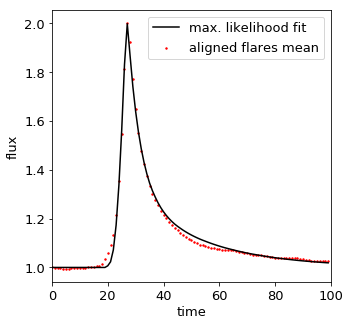

In [256]:
plt.figure(figsize=(5,5))
plt.scatter(time, flux+1., s=2, c="r", label="aligned flares mean")
plt.plot(time, aflare(time, tpeak_ml, dur_ml, ampl_ml)+1, c="k", label="max. likelihood fit")
plt.xlim(0,100)
plt.xlabel("time")
plt.ylabel("flux")
plt.legend()
plt.savefig(f"../plots/{tstamp}_landmark_registration_linear_{S}_fit.png")

In [187]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [188]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(time, flux, flux_err))

In [189]:
sampler.run_mcmc(pos, 500)

State([[26.85027038 14.44106265  1.03553225]
 [26.80417771 14.03504459  1.05534203]
 [26.82598964 14.41914031  1.03760787]
 [26.81048761 14.08574992  1.05679898]
 [26.79484804 13.91458771  1.0581537 ]
 [26.82225863 14.10406297  1.05362043]
 [26.8312551  14.18480653  1.05367675]
 [26.83226445 14.2302775   1.05587466]
 [26.80990465 14.3066431   1.05062743]
 [26.8245303  14.65950005  1.03791842]
 [26.82288785 13.99821741  1.05619107]
 [26.82552624 14.27683172  1.04881248]
 [26.81128764 14.41714158  1.04953461]
 [26.8138877  14.223915    1.0538333 ]
 [26.83658878 14.54072681  1.0324934 ]
 [26.8416437  14.22007526  1.0554734 ]
 [26.80943712 14.25123797  1.05254087]
 [26.82369752 14.18650306  1.05438824]
 [26.82823532 14.19571631  1.05560933]
 [26.84182599 14.3268707   1.04391396]
 [26.83553759 14.33452288  1.04574513]
 [26.83631367 14.30324938  1.05062768]
 [26.8357821  14.16778419  1.05414627]
 [26.82510135 14.3053746   1.05919576]
 [26.84440895 14.42292575  1.04337454]
 [26.84126344 14.48

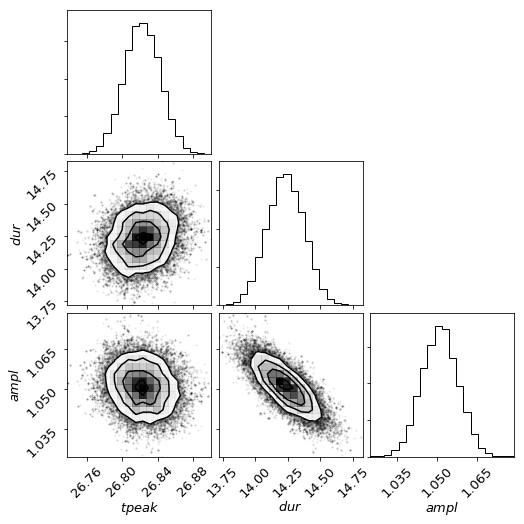

In [190]:

import corner
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$tpeak$", "$dur$", "$ampl$"],)
                     # truths=[m_true, b_true, np.log(f_true)])

<ErrorbarContainer object of 3 artists>

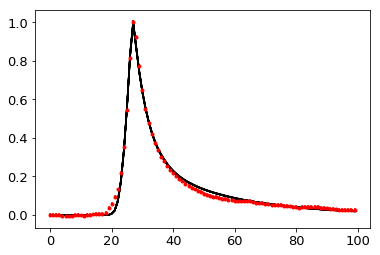

In [199]:
xl = np.array([0, 100])
for tpeak, dur, ampl in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(time, aflare(time, tpeak, dur, ampl), color="k", alpha=0.1)
#plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(time, flux, yerr=flux_err, fmt=".r")

In [111]:
def lnprior(theta):
    tpeak, dur, ampl = theta
    if 0 < tpeak < 100 and 0.0 < dur and 0.0 < ampl:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglikelihood(theta, x, y, yerr)

def loglikelihood(theta, time, y, yerr):
    tpeak, dur, ampl = theta
    m = aflare(time, tpeak, dur, ampl)
    return -.5 * np.sum((y - m)**2 / yerr**2 + np.log(2 * np.pi * yerr**2)) 

def aflare(t, tpeak, dur, ampl, upsample=True, uptime=10):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Use this function for fitting classical flares with most curve_fit
    tools.
    Note: this model assumes the flux before the flare is zero centered
    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    dur : float
        The duration of the flare
    ampl : float
        The amplitude of the flare
    upsample : bool
        If True up-sample the model flare to ensure more precise energies.
    uptime : float
        How many times to up-sample the data (Default is 10)
    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    fwhm = dur/2. # crude approximation for a triangle shape would be dur/2.
    
    if upsample:
        dt = np.nanmedian(np.diff(t))
        timeup = np.linspace(min(t)-dt, max(t)+dt, t.size * uptime)

        flareup = np.piecewise(timeup, [(timeup<= tpeak) * (timeup-tpeak)/fwhm > -1.,
                                        (timeup > tpeak)],
                                    [lambda x: (_fr[0]+                       # 0th order
                                                _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                                _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                                _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                                _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                     lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                                _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                    ) * np.abs(ampl) # amplitude

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t-dt/2.,[max(t)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',
                                     bins=downbins)

    else:
        flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                 (t > tpeak)],
                                [lambda x: (_fr[0]+                       # 0th order
                                            _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                            _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                            _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                            _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                 lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                            _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                ) * np.abs(ampl) # amplitude
      

    return flare



In [85]:
from scipy.stats import binned_statistic